# Installations

The installation is mostly automated.

A file in the same directory named "thesis_ro" will be required, which should contain your GitHub read-only token.

The file has one line:


`echo "GITHUB_PERSONAL_ACCESS_TOKEN="ghp_..." > thesis_ro`

In [1]:
import sys
import os
import subprocess

IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
  pass

else:
  subprocess.run('''
    source <(curl -s https://raw.githubusercontent.com/norandom/log2ml/main/dependencies/install.sh)
    ''',
    shell=True, check=True, executable='/bin/bash')



# Setup data

The data setup is automated, based on GitHub release files.

In [2]:
from dotenv import load_dotenv
import os

load_dotenv("thesis_ro", verbose=True)  # take environment variables from the file
token = os.getenv('GITHUB_PERSONAL_ACCESS_TOKEN')
if len(token) > 0:
  print("ok")
else:
  print("no token")

ok


In [3]:
from github import Github
import requests
from tqdm.notebook import tqdm


def get_specific_file_from_tagged_release(token, repo_name, tag_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    releases = repo.get_releases()

    for release in releases:
        if release.tag_name == tag_name:
            for asset in release.get_assets():
                if asset.name == filename:
                    return asset.url
    print("File not found. Try get_specific_file_from_latest_release() instead.")
    return None

def get_specific_file_from_latest_release(token, repo_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    release = repo.get_latest_release()

    for asset in release.get_assets():
        if asset.name == filename:
            return asset.url  # Use asset.url which points to API URL needing headers

def download_file(url, token, save_path):
    headers = {'Authorization': f'token {token}', 'Accept': 'application/octet-stream'}
    # First request to handle GitHub's redirection and authentication properly
    with requests.get(url, headers=headers, stream=True) as initial_response:
        initial_response.raise_for_status()  # Ensure the initial request is successful
        # Follow redirection if necessary, maintaining headers
        if initial_response.history:
            url = initial_response.url  # Updated URL after redirection

        # Now, proceed with downloading the file
        with requests.get(url, headers=headers, stream=True) as response:
            response.raise_for_status()
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            block_size = 1024

            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(save_path, 'wb') as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()

            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")
            else:
                print(f"File downloaded successfully and saved as {save_path}")

# Your GitHub token
github_token = token

# Repository name
repository_name = "norandom/log2ml"

# File name to search for
file_name = "lab_logs_normal_activity_may_11_2024.csv"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "foundations", file_name)
print(download_url)

if download_url:
    local_file_path = "lab_logs_normal_activity_may_11_2024.csv"
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/168248751


  0%|          | 0.00/1.43G [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_normal_activity_may_11_2024.csv


# Train custom Tokenizer with complex dataset

The dataset contains security-agent telemetry from MS Sysmon.
Therefore a custom Tokenizer is needed, given that the content isn't 100% natural language.

BPE stands for Byte Pair Encoding Tokenization

"It’s used by a lot of Transformer models, including GPT, GPT-2, RoBERTa, BART, and DeBERTa." [1]

Given that LongFormer and Linformer are Transformer Network architectures, BPE is a compatible choice.

[1] https://huggingface.co/learn/nlp-course/en/chapter6/5

In [7]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Initialize the tokenizer
tokenizer = Tokenizer(BPE())

# Setup pre-tokenizer
tokenizer.pre_tokenizer = Whitespace()

# Setup trainer
trainer = BpeTrainer(
    vocab_size=30000,
    min_frequency=2,
    special_tokens=["=", ":", ",", "\"", "\'", "(", ")", "[", "]", "{", "}"],
    show_progress=True
)

# Train the tokenizer on your log data
tokenizer.train(files=["lab_logs_normal_activity_may_11_2024.csv"], trainer=trainer)

# Save the tokenizer
tokenizer.save("log_tokenizer.json")

In [8]:
log_text = """
@timestamp,host.hostname,host.ip,log.level,winlog.event_id,winlog.task,message
2024-07-28T15:09:33.716Z,win10,fe80::c1af:35de:6006:d4cf,information,13,Registry value set (rule: RegistryEvent),"Registry value set:
RuleName: InvDB-Ver
EventType: SetValue
UtcTime: 2024-07-28 15:09:33.716
ProcessGuid: {18e8265a-5ee4-66a6-5400-000000004400}
ProcessId: 4032
Image: C:\Windows\System32\svchost.exe
TargetObject: \REGISTRY\A\{90cbbb87-bac4-4fa3-1d8b-b1a042a75259}\Root\InventoryApplicationFile\ie4uinit.exe|874b2700383dd346\BinProductVersion
Details: 11.0.19041.4648"
"""

# Tokenize your log_text
output = tokenizer.encode(log_text)

# Print the tokens
print(output.tokens)

# If you want to get the IDs of the tokens
print(output.ids)

['@', 'tim', 'est', 'amp', ',', 'host', '.', 'hostname', ',', 'host', '.', 'ip', ',', 'log', '.', 'level', ',', 'winlog', '.', 'event', '_id', ',', 'winlog', '.', 'task', ',', 'message', '2024', '-', '07', '-', '28T', '15', ':', '09', ':', '33', '.', '716Z', ',', 'win10', ',', 'fe80', ':', ':', 'c', '1af', ':', '35', 'de', ':', '600', '6', ':', 'd4c', 'f', ',', 'information', ',', '13', ',', 'Registry', 'value', 'set', '(', 'rule', ':', 'RegistryEvent', ')', ',', '"', 'Registry', 'value', 'set', ':', 'RuleName', ':', 'InvDB', '-', 'Ver', 'EventType', ':', 'SetValue', 'UtcTime', ':', '2024', '-', '07', '-', '28', '15', ':', '09', ':', '33', '.', '716', 'ProcessGuid', ':', '{', '18e8265a', '-', '5e', 'e4', '-', '6', '6a', '6', '-', '5400', '-', '00000000', '4400', '}', 'ProcessId', ':', '4032', 'Image', ':', 'C', ':', '\\', 'Windows', '\\', 'System32', '\\', 'svchost', '.', 'exe', 'TargetObject', ':', '\\', 'REGISTRY', '\\', 'A', '\\', '{', '90', 'cbb', 'b87', '-', 'bac', '4', '-', '4fa'

# Download dataset to use

The analysis dataset has less complex data.

In [9]:
# File name to search for
file_name = "lab_logs_blindtest_activity_june_25_2024.csv"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "foundations", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/175872904


  0%|          | 0.00/594k [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_june_25_2024.csv


# ETL dataset

ETL stands for Extract, Transform, Load. Polars is used as an ETL framework. It allows DataFrame operations, similar to Pandas.

In [10]:
import polars as pl

csv_file_path = 'lab_logs_blindtest_activity_june_25_2024.csv'

# Load the CSV file into a DataFrame
df = pl.read_csv(csv_file_path)

# Show the DataFrame to confirm it's loaded correctly
print(df)

shape: (1_027, 5)
┌───────┬─────────────┬─────────────────┬───────────────────────────────────┬─────────────────────┐
│ index ┆ log.level   ┆ winlog.event_id ┆ winlog.task                       ┆ filtered_message    │
│ ---   ┆ ---         ┆ ---             ┆ ---                               ┆ ---                 │
│ i64   ┆ str         ┆ i64             ┆ str                               ┆ str                 │
╞═══════╪═════════════╪═════════════════╪═══════════════════════════════════╪═════════════════════╡
│ 0     ┆ information ┆ 10              ┆ Process accessed (rule: ProcessA… ┆ Process accessed:   │
│       ┆             ┆                 ┆                                   ┆ RuleName: -         │
│       ┆             ┆                 ┆                                   ┆ So…                 │
│ 1     ┆ information ┆ 10              ┆ Process accessed (rule: ProcessA… ┆ Process accessed:   │
│       ┆             ┆                 ┆                                   ┆ Rule

In [11]:
import re

# Extract relevant information using regular expressions
def extract_info(text):
    image = re.search(r"Image: (.*?\.exe)", text, re.IGNORECASE)
    target_filename = re.search(r"TargetFilename: (.*?\.exe)", text, re.IGNORECASE)
    return {
        "image": image.group(1) if image else "",
        "target_filename": target_filename.group(1) if target_filename else "",
        "text": text
    }

# Apply extraction to the Polars DataFrame using map_elements
better_columns_df = df.with_columns(
    pl.col("filtered_message").map_elements(lambda x: extract_info(x), return_dtype=pl.Object).alias("extracted_info")
)

# Extract fields from the extracted_info column using map_elements with return_dtype
better_columns_df = better_columns_df.with_columns(
    pl.col("extracted_info").map_elements(lambda x: x['image'], return_dtype=pl.Utf8).alias("image"),
    pl.col("extracted_info").map_elements(lambda x: x['target_filename'], return_dtype=pl.Utf8).alias("target_filename"),
    pl.col("extracted_info").map_elements(lambda x: x['text'], return_dtype=pl.Utf8).alias("text")
).drop("extracted_info")

print(better_columns_df)

shape: (1_027, 8)
┌───────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ index ┆ log.level  ┆ winlog.eve ┆ winlog.tas ┆ filtered_m ┆ image      ┆ target_fil ┆ text       │
│ ---   ┆ ---        ┆ nt_id      ┆ k          ┆ essage     ┆ ---        ┆ ename      ┆ ---        │
│ i64   ┆ str        ┆ ---        ┆ ---        ┆ ---        ┆ str        ┆ ---        ┆ str        │
│       ┆            ┆ i64        ┆ str        ┆ str        ┆            ┆ str        ┆            │
╞═══════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 0     ┆ informatio ┆ 10         ┆ Process    ┆ Process    ┆ C:\Windows ┆            ┆ Process    │
│       ┆ n          ┆            ┆ accessed   ┆ accessed:  ┆ \system32\ ┆            ┆ accessed:  │
│       ┆            ┆            ┆ (rule:     ┆ RuleName:  ┆ svchost.ex ┆            ┆ RuleName:  │
│       ┆            ┆            ┆ ProcessA…  ┆ -          ┆ e          

# Max token length

Selecting models which can deal with the long Sysmon agent messages is a key design requirement for the ML pipeline. Therefore the maximum token lengt

In [15]:
from tokenizers import Tokenizer

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Tokenize the messages and calculate total tokens
token_lengths = better_columns_df["filtered_message"].map_elements(
    lambda x: len(tokenizer.encode(x).ids)
)

# Get the total input token count
total_input_tokens = token_lengths.sum()

print(f"The total number of input tokens in 'filtered_message' column is: {total_input_tokens}")

# Cost calculation
input_cost_per_1m_tokens = 10.00  # $10.00 per 1M tokens for input
output_cost_per_1m_tokens = 30.00  # $30.00 per 1M tokens for output

# Estimate output tokens (this is an assumption, adjust as needed)
estimated_output_tokens = total_input_tokens * 0.5  # Assuming output is 50% of input

# Calculate costs
input_cost = (total_input_tokens / 1_000_000) * input_cost_per_1m_tokens
output_cost = (estimated_output_tokens / 1_000_000) * output_cost_per_1m_tokens
total_cost = input_cost + output_cost

print("Reference: OpenAI GPT4-turbo July 2022")
print(f"Estimated input cost: ${input_cost:.2f}")
print(f"Estimated output cost: ${output_cost:.2f}")
print(f"Estimated total cost: ${total_cost:.2f}")

The total number of input tokens in 'filtered_message' column is: 157897
Reference: OpenAI GPT4-turbo July 2022
Estimated input cost: $1.58
Estimated output cost: $2.37
Estimated total cost: $3.95


# Load LinFormer with max. token length

In [16]:
import torch
torch.cuda.empty_cache()

In [17]:
# Linformer parameter 1:1 from the researchers
# then the input_size is determined based on the max no. of tokens
# the positional embedding flag is on by default

from linformer_pytorch import LinformerLM
import torch

linformer_model = LinformerLM(
        num_tokens=30000, # Number of tokens in the LM
        input_size=700, # Dimension 1 of the input
        channels=64, # Dimension 2 of the input
        dim_d=None, # Overwrites the inner dim of the attention heads. If None, sticks with the recommended channels // nhead, as in the "Attention is all you need" paper
        dim_k=128, # The second dimension of the P_bar matrix from the paper
        dim_ff=128, # Dimension in the feed forward network
        dropout_ff=0.15, # Dropout for feed forward network
        nhead=4, # Number of attention heads
        depth=2, # How many times to run the model
        dropout=0.1, # How much dropout to apply to P_bar after softmax
        activation="gelu", # What activation to use. Currently, only gelu and relu supported, and only on ff network.
        checkpoint_level="C0", # What checkpoint level to use. For more information, see below.
        parameter_sharing="layerwise", # What level of parameter sharing to use. For more information, see below.
        k_reduce_by_layer=0, # Going down `depth`, how much to reduce `dim_k` by, for the `E` and `F` matrices. Will have a minimum value of 1.
        full_attention=False, # Use full attention instead, for O(n^2) time and space complexity. Included here just for comparison
        include_ff=True, # Whether or not to include the Feed Forward layer
        w_o_intermediate_dim=None, # If not None, have 2 w_o matrices, such that instead of `dim*nead,channels`, you have `dim*nhead,w_o_int`, and `w_o_int,channels`
        emb_dim=128, # If you want the embedding dimension to be different than the channels for the Linformer
        causal=False, # If you want this to be a causal Linformer, where the upper right of the P_bar matrix is masked out.
        method="learnable", # The method of how to perform the projection. Supported methods are 'convolution', 'learnable', and 'no_params'
        ff_intermediate=None, # See the section below for more information
        ).cuda()

# Vectorize the text column in that DataFrame

In [18]:
from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def vectorize_text(text):
    MAX_LENGTH = 700  # Define the maximum length of tokens for the model

    # Tokenize using the custom tokenizer
    encoded = tokenizer.encode(text)

    # Get token IDs
    input_ids = encoded.ids

    # Ensure the input_ids length is exactly MAX_LENGTH
    input_ids = input_ids[:MAX_LENGTH] if len(input_ids) > MAX_LENGTH else input_ids + [0] * (MAX_LENGTH - len(input_ids))

    # Convert to PyTorch tensor and move to the appropriate device
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Get the model outputs, ensuring the input tensor is the correct size
    outputs = linformer_model(input_ids)  # Now passing the tensor directly

    # Assuming outputs is the tensor of interest
    vector = outputs.mean(dim=1).detach()  # Detach the tensor from the GPU
    return vector.cpu().numpy()  # Move tensor back to CPU and convert to numpy

# Assuming `better_columns_df` is a Polars DataFrame with a column "filtered_message"
linformer_vector_df = better_columns_df.with_columns(
    pl.col("filtered_message").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("message_vector")
)

print(linformer_vector_df)


shape: (1_027, 9)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ index ┆ log.level  ┆ winlog.eve ┆ winlog.tas ┆ … ┆ image     ┆ target_fi ┆ text      ┆ message_v │
│ ---   ┆ ---        ┆ nt_id      ┆ k          ┆   ┆ ---       ┆ lename    ┆ ---       ┆ ector     │
│ i64   ┆ str        ┆ ---        ┆ ---        ┆   ┆ str       ┆ ---       ┆ str       ┆ ---       │
│       ┆            ┆ i64        ┆ str        ┆   ┆           ┆ str       ┆           ┆ object    │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0     ┆ informatio ┆ 10         ┆ Process    ┆ … ┆ C:\Window ┆           ┆ Process   ┆ [ 0.18137 │
│       ┆ n          ┆            ┆ accessed   ┆   ┆ s\system3 ┆           ┆ accessed: ┆ 093 -0.25 │
│       ┆            ┆            ┆ (rule:     ┆   ┆ 2\svchost ┆           ┆ RuleName: ┆ 33698     │
│       ┆            ┆            ┆ ProcessA…  ┆   ┆ .exe      ┆         

In [ ]:
# Ensure memory_profiler is installed
!pip install -q memory-profiler

import timeit
from memory_profiler import memory_usage
import polars as pl
import numpy as np
import torch

# Function to process the DataFrame and measure memory usage
def process_and_measure(df):
    # Reset GPU memory peak stats
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    temp_df = df.with_columns(
        pl.col("filtered_message").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("message_vector")
    )

    # Get GPU memory usage
    gpu_memory_usage = torch.cuda.max_memory_allocated() / (1024 ** 2) if torch.cuda.is_available() else 0
    return gpu_memory_usage

# Number of times to run the function
n_runs = 10

# Measure the runtime, CPU, and GPU memory usage over multiple runs
runtimes = []
cpu_memory_usages = []
gpu_memory_usages = []

for _ in range(n_runs):
    # Measure runtime
    runtime = timeit.timeit(lambda: process_and_measure(better_columns_df), number=1)
    runtimes.append(runtime)

    # Measure CPU memory usage
    cpu_mem_usage = memory_usage((process_and_measure, (better_columns_df,)))
    cpu_memory_usages.append(max(cpu_mem_usage) - min(cpu_mem_usage))

    # Measure GPU memory usage
    gpu_mem_usage = process_and_measure(better_columns_df)
    gpu_memory_usages.append(gpu_mem_usage)

# Calculate average runtime, CPU memory, and GPU memory usage
average_runtime = np.mean(runtimes)
average_cpu_memory_usage = np.mean(cpu_memory_usages)
average_gpu_memory_usage = np.mean(gpu_memory_usages)

print(f"Average runtime over {n_runs} runs: {average_runtime:.6f} seconds")
print(f"Average CPU memory usage over {n_runs} runs: {average_cpu_memory_usage:.2f} MiB")
print(f"Average GPU memory usage over {n_runs} runs: {average_gpu_memory_usage:.2f} MiB")


Average runtime over 10 runs: 7.183239 seconds
Average CPU memory usage over 10 runs: 116.41 MiB
Average GPU memory usage over 10 runs: 131.21 MiB


# Convert the vectors to a NumPy array for statistical analysis

In [19]:
# Assuming vector_df has a column 'message_vector' with the vectors
linformer_vectors = np.stack(linformer_vector_df['message_vector'].to_numpy())  # Stack the vectors into a 2D array

# UMAP dimensionality check - scattered or clustered?

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


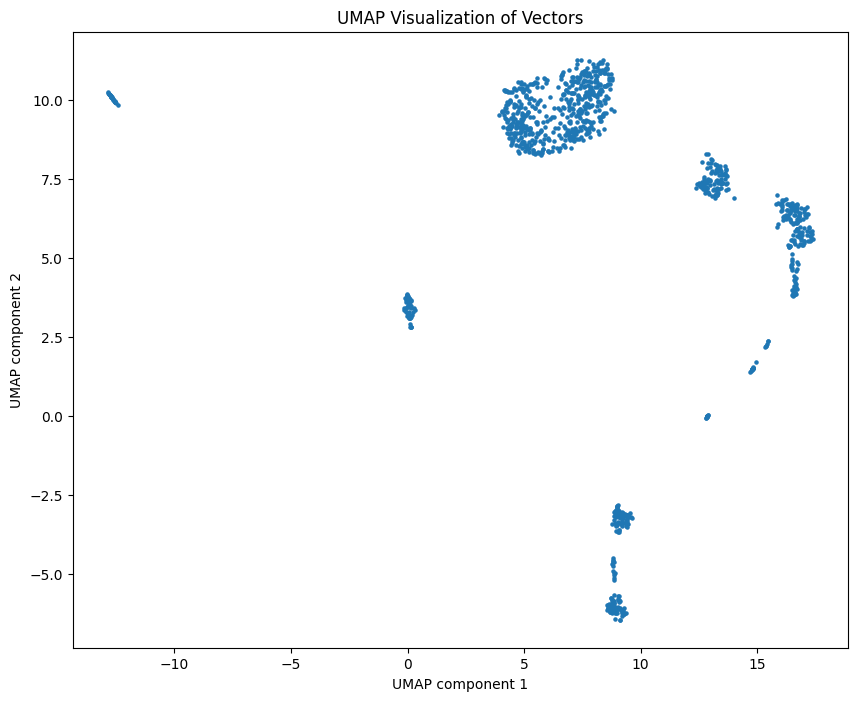

In [20]:
import umap.umap_ as umap  # Correct import statement for UMAP

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(linformer_vectors)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=5)
plt.title('UMAP Visualization of Vectors')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.show()


# Silhouette score via KMeans clustering

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming we choose an arbitrary number of clusters, e.g., 5
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(linformer_vectors)

# Calculate the silhouette score
sil_score = silhouette_score(linformer_vectors, cluster_labels)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.7105976939201355


# Distribution of the Cosine similarity

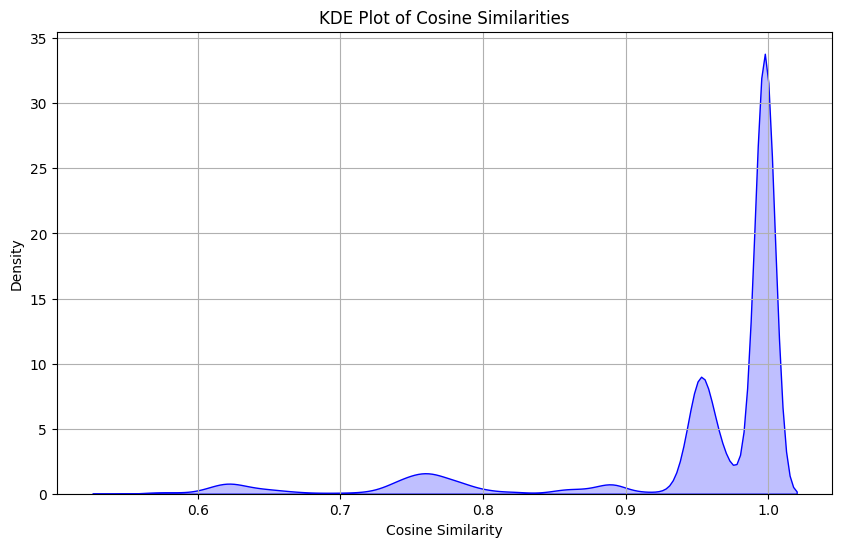

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming vector_df has a column 'message_vector' with the vectors
vectors = np.stack(linformer_vector_df['message_vector'].to_numpy())  # Stack the vectors into a 2D array

# Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(linformer_vectors)

# Extract the upper triangle values from the cosine similarity matrix, excluding the diagonal
upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
cosine_sim_values = cosine_sim_matrix[upper_triangle_indices]

# Plotting the KDE of cosine similarities
plt.figure(figsize=(10, 6))
sns.kdeplot(cosine_sim_values, color='blue', fill=True)
plt.title('KDE Plot of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.grid(True)
plt.show()



# Comparison LongFormer

In [ ]:
# starts with the same data
print(better_columns_df)

shape: (1_027, 8)
┌───────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ index ┆ log.level  ┆ winlog.eve ┆ winlog.tas ┆ filtered_m ┆ image      ┆ target_fil ┆ text       │
│ ---   ┆ ---        ┆ nt_id      ┆ k          ┆ essage     ┆ ---        ┆ ename      ┆ ---        │
│ i64   ┆ str        ┆ ---        ┆ ---        ┆ ---        ┆ str        ┆ ---        ┆ str        │
│       ┆            ┆ i64        ┆ str        ┆ str        ┆            ┆ str        ┆            │
╞═══════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 0     ┆ informatio ┆ 10         ┆ Process    ┆ Process    ┆ C:\Windows ┆            ┆ Process    │
│       ┆ n          ┆            ┆ accessed   ┆ accessed:  ┆ \system32\ ┆            ┆ accessed:  │
│       ┆            ┆            ┆ (rule:     ┆ RuleName:  ┆ svchost.ex ┆            ┆ RuleName:  │
│       ┆            ┆            ┆ ProcessA…  ┆ -          ┆ e          

# Initialize and use LongFormer with the same pre-trained Tokenizer

In [29]:
from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl
from transformers import LongformerModel

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Load LongFormer model
model_name = 'allenai/longformer-base-4096'
longformer_model = LongformerModel.from_pretrained(model_name)

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
longformer_model.to(device)

def vectorize_text(text):
    MAX_LENGTH = 700  # Define the maximum length of tokens for the model

    # Tokenize using the custom tokenizer
    encoded = tokenizer.encode(text)

    # Get token IDs
    input_ids = encoded.ids

    # Ensure the input_ids length is exactly MAX_LENGTH
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
    else:
        input_ids = input_ids + [0] * (MAX_LENGTH - len(input_ids))

    # Convert to PyTorch tensor and move to the appropriate device
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Create attention mask: 1 for non-padding, 0 for padding
    attention_mask = (input_ids != 0).long()

    # Get the model outputs, ensuring the input tensor is the correct size
    with torch.no_grad():
        outputs = longformer_model(input_ids, attention_mask=attention_mask)
        vector = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Average over the token embeddings
    return vector.flatten()  # Flatten the array to 1D if needed

# Assuming `better_columns_df` is your Polars DataFrame with a column "filtered_message"
longformer_vector_df = better_columns_df.with_columns(
    pl.col("filtered_message").map_elements(vectorize_text, return_dtype=pl.Object).alias("message_vector")
)

print(longformer_vector_df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Input ids are automatically padded from 700 to 1024 to be a multiple of `config.attention_window`: 512


shape: (1_027, 9)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ index ┆ log.level  ┆ winlog.eve ┆ winlog.tas ┆ … ┆ image     ┆ target_fi ┆ text      ┆ message_v │
│ ---   ┆ ---        ┆ nt_id      ┆ k          ┆   ┆ ---       ┆ lename    ┆ ---       ┆ ector     │
│ i64   ┆ str        ┆ ---        ┆ ---        ┆   ┆ str       ┆ ---       ┆ str       ┆ ---       │
│       ┆            ┆ i64        ┆ str        ┆   ┆           ┆ str       ┆           ┆ object    │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0     ┆ informatio ┆ 10         ┆ Process    ┆ … ┆ C:\Window ┆           ┆ Process   ┆ [ 1.66481 │
│       ┆ n          ┆            ┆ accessed   ┆   ┆ s\system3 ┆           ┆ accessed: ┆ 603e-02   │
│       ┆            ┆            ┆ (rule:     ┆   ┆ 2\svchost ┆           ┆ RuleName: ┆ 5.9788990 │
│       ┆            ┆            ┆ ProcessA…  ┆   ┆ .exe      ┆         

In [ ]:
!pip install -q psutil

import timeit
import psutil
import polars as pl
import torch

# Function to process the DataFrame and measure memory usage
def process_and_measure(df):
    # Reset GPU memory peak stats
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    temp_df = df.with_columns(
        pl.col("filtered_message").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("message_vector")
    )

    # Get GPU memory usage
    gpu_memory_usage = torch.cuda.max_memory_allocated() / (1024 ** 2) if torch.cuda.is_available() else 0
    return gpu_memory_usage

# Number of times to run the function
n_runs = 10

# Measure the runtime, CPU, and GPU memory usage over multiple runs
runtimes = []
cpu_memory_usages = []
gpu_memory_usages = []

for _ in range(n_runs):
    # Record initial CPU memory usage
    # psutil, because JAX doesn't work well with the memory_profiler
    initial_memory = psutil.Process().memory_info().rss / (1024 ** 2)

    # Measure runtime
    runtime = timeit.timeit(lambda: process_and_measure(better_columns_df), number=1)
    runtimes.append(runtime)

    # Record final CPU memory usage
    final_memory = psutil.Process().memory_info().rss / (1024 ** 2)
    cpu_memory_usages.append(final_memory - initial_memory)

    # Measure GPU memory usage
    gpu_mem_usage = process_and_measure(better_columns_df)
    gpu_memory_usages.append(gpu_mem_usage)

# Calculate average runtime, CPU memory, and GPU memory usage
average_runtime = np.mean(runtimes)
average_cpu_memory_usage = np.mean(cpu_memory_usages)
average_gpu_memory_usage = np.mean(gpu_memory_usages)

print(f"Average runtime over {n_runs} runs: {average_runtime:.6f} seconds")
print(f"Average CPU memory usage over {n_runs} runs: {average_cpu_memory_usage:.2f} MiB")
print(f"Average GPU memory usage over {n_runs} runs: {average_gpu_memory_usage:.2f} MiB")


Average runtime over 10 runs: 32.509051 seconds
Average CPU memory usage over 10 runs: 0.00 MiB
Average GPU memory usage over 10 runs: 739.78 MiB


In [31]:
# Assuming vector_df has a column 'message_vector' with the vectors
longformer_vectors = np.stack(longformer_vector_df['message_vector'].to_numpy())  # Stack the vectors into a 2D array

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


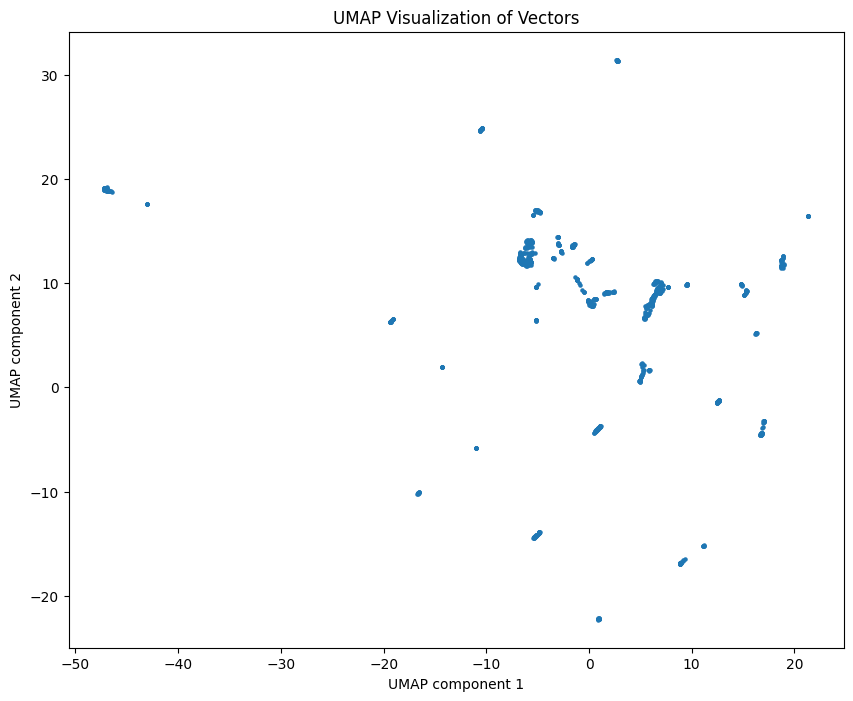

In [ ]:
import umap.umap_ as umap  # Correct import statement for UMAP

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(longformer_vectors)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=5)
plt.title('UMAP Visualization of Vectors')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming we choose an arbitrary number of clusters, e.g., 5
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(longformer_vectors)

# Calculate the silhouette score
sil_score = silhouette_score(longformer_vectors, cluster_labels)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.7029939889907837


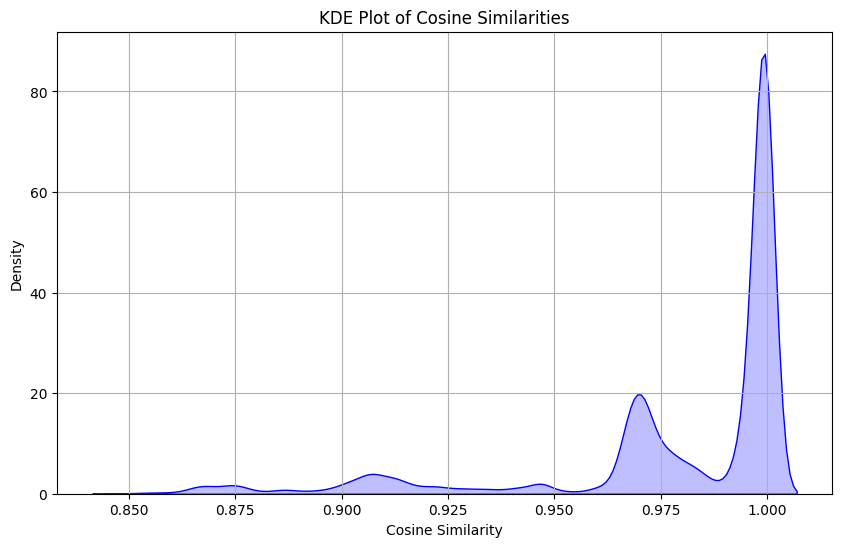

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming vector_df has a column 'message_vector' with the vectors
vectors = np.stack(longformer_vector_df['message_vector'].to_numpy())  # Stack the vectors into a 2D array

# Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(longformer_vectors)

# Extract the upper triangle values from the cosine similarity matrix, excluding the diagonal
upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
cosine_sim_values = cosine_sim_matrix[upper_triangle_indices]

# Plotting the KDE of cosine similarities
plt.figure(figsize=(10, 6))
sns.kdeplot(cosine_sim_values, color='blue', fill=True)
plt.title('KDE Plot of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.grid(True)
plt.show()



In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming `X` is the matrix of extracted features from your deep learning model
# Replace this with your actual feature matrix
X = linformer_vectors

# Scale the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Output the results
num_features_before = X.shape[1]
num_features_after = X_pca.shape[1]
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)

print("For Standard Scaler")
print(f"Number of features before PCA: {num_features_before}")
print(f"Number of features after PCA: {num_features_after}")
print(f"Explained variance ratio of each component: {explained_variance_ratio}")
print(f"Total explained variance: {total_explained_variance}")


Number of features before PCA: 30000
Number of features after PCA: 16
Explained variance ratio of each component: [0.7322417  0.10258386 0.01919063 0.01368955 0.01286633 0.01047001
 0.00869492 0.00842645 0.00745646 0.00658019 0.00584541 0.00514998
 0.00491944 0.00477372 0.00384961 0.00355314]
Total explained variance: 0.9502913951873779


In [24]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# Assuming `X` is the matrix of extracted features from your deep learning model
# Replace this with your actual feature matrix
X = linformer_vectors

# Scale the features before applying PCA
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Output the results
num_features_before = X.shape[1]
num_features_after = X_pca.shape[1]
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)

print("For Robust Scaler:")
print(f"Number of features before PCA: {num_features_before}")
print(f"Number of features after PCA: {num_features_after}")
print(f"Explained variance ratio of each component: {explained_variance_ratio}")
print(f"Total explained variance: {total_explained_variance}")

For Robust Scaler:
Number of features before PCA: 30000
Number of features after PCA: 12
Explained variance ratio of each component: [0.780261   0.10317536 0.0133233  0.00962587 0.00900306 0.00735111
 0.00611507 0.00592202 0.00531727 0.00460212 0.00413254 0.00365149]
Total explained variance: 0.952480137348175


In [25]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
import numpy as np

# Assuming X is your feature matrix
X = linformer_vectors

# Initialize and fit QuantileTransformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
X_scaled = qt.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Output results
num_features_before = X.shape[1]
num_features_after = X_pca.shape[1]
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)

print("For QuantileTransformer:")
print(f"Number of features before PCA: {num_features_before}")
print(f"Number of features after PCA: {num_features_after}")
print(f"Explained variance ratio of each component: {explained_variance_ratio}")
print(f"Total explained variance: {total_explained_variance}")

For QuantileTransformer:
Number of features before PCA: 30000
Number of features after PCA: 44
Explained variance ratio of each component: [0.5520516  0.06681303 0.03466679 0.02603397 0.02438432 0.01991471
 0.01807965 0.01676909 0.01452703 0.01407685 0.01204457 0.01079712
 0.01011274 0.00953582 0.00818911 0.00781149 0.00750947 0.00684127
 0.00666759 0.00635126 0.0060087  0.00576267 0.00530005 0.00508402
 0.0044879  0.00436854 0.00426688 0.0040915  0.00363791 0.00351764
 0.00315828 0.00294013 0.00270898 0.00254636 0.0024569  0.00226332
 0.0022466  0.00212357 0.00194851 0.00179851 0.0016702  0.00165001
 0.00159225 0.00152319]
Total explained variance: 0.9503300786018372


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming `X` is the matrix of extracted features from your deep learning model
# Replace this with your actual feature matrix
X = longformer_vectors

# Scale the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Output the results
num_features_before = X.shape[1]
num_features_after = X_pca.shape[1]
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)

print(f"Number of features before PCA: {num_features_before}")
print(f"Number of features after PCA: {num_features_after}")
print(f"Explained variance ratio of each component: {explained_variance_ratio}")
print(f"Total explained variance: {total_explained_variance}")


Number of features before PCA: 768
Number of features after PCA: 12
Explained variance ratio of each component: [0.61036086 0.20625743 0.0349943  0.02877296 0.01811446 0.01343036
 0.01034578 0.00865575 0.00768904 0.0061328  0.00457506 0.00375366]
Total explained variance: 0.9530825018882751


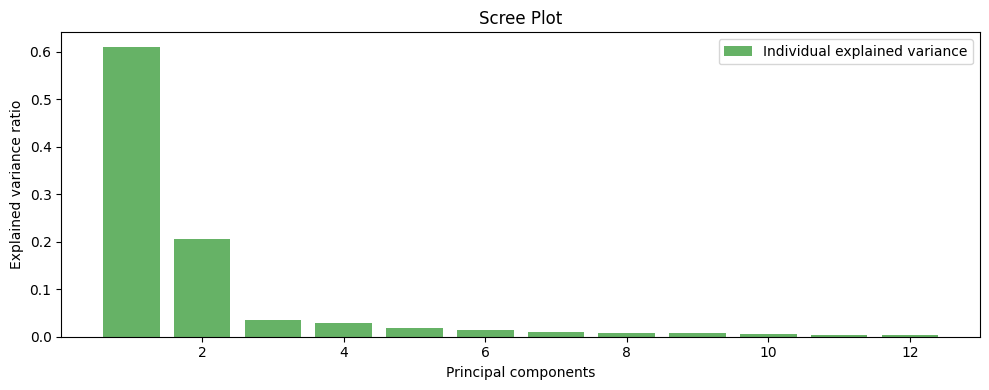

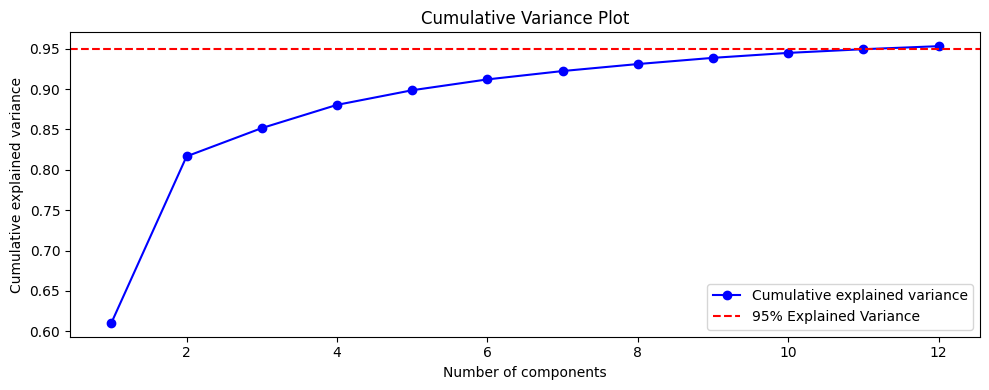

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# X is the features matrix
x = linformer_vectors


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the Scree plot
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='g', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.tight_layout()

# Plotting the Cumulative Variance plot
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Variance Plot')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend(loc='best')
plt.tight_layout()

# Displaying the plots
plt.show()


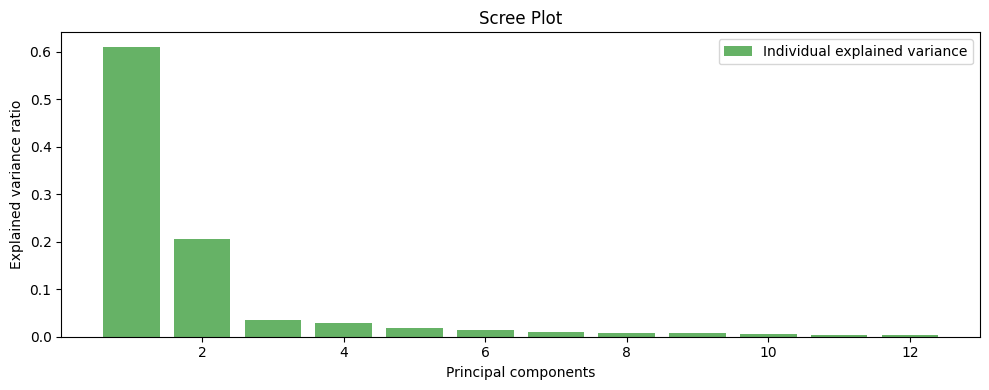

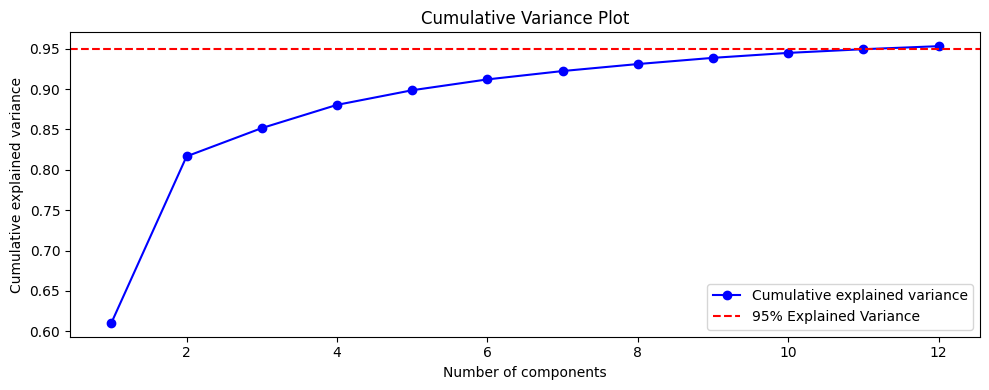

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# X is the features matrix
x = longformer_vectors


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the Scree plot
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='g', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.tight_layout()

# Plotting the Cumulative Variance plot
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Variance Plot')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend(loc='best')
plt.tight_layout()

# Displaying the plots
plt.show()


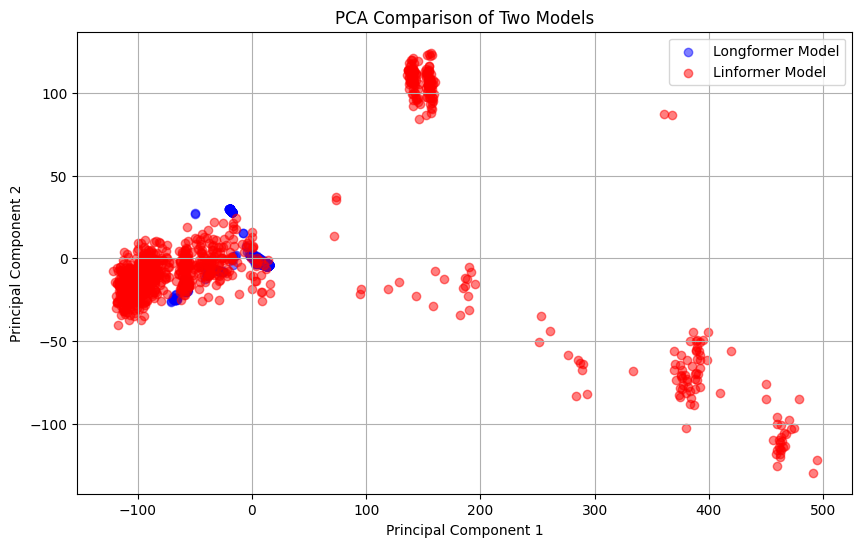

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_1 = longformer_vectors
X_2 = linformer_vectors

# Standardize the features independently
scaler1 = StandardScaler()
X_1_scaled = scaler1.fit_transform(X_1)

scaler2 = StandardScaler()
X_2_scaled = scaler2.fit_transform(X_2)

# Apply PCA
pca = PCA(n_components=2)  # Reducing to 2 components for a 2D plot
X_1_pca = pca.fit_transform(X_1_scaled)
pca2 = PCA(n_components=2)
X_2_pca = pca2.fit_transform(X_2_scaled)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_1_pca[:, 0], X_1_pca[:, 1], color='blue', alpha=0.5, label='Longformer Model')
plt.scatter(X_2_pca[:, 0], X_2_pca[:, 1], color='red', alpha=0.5, label='Linformer Model')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Comparison of Two Models')
plt.legend()
plt.grid(True)
plt.show()


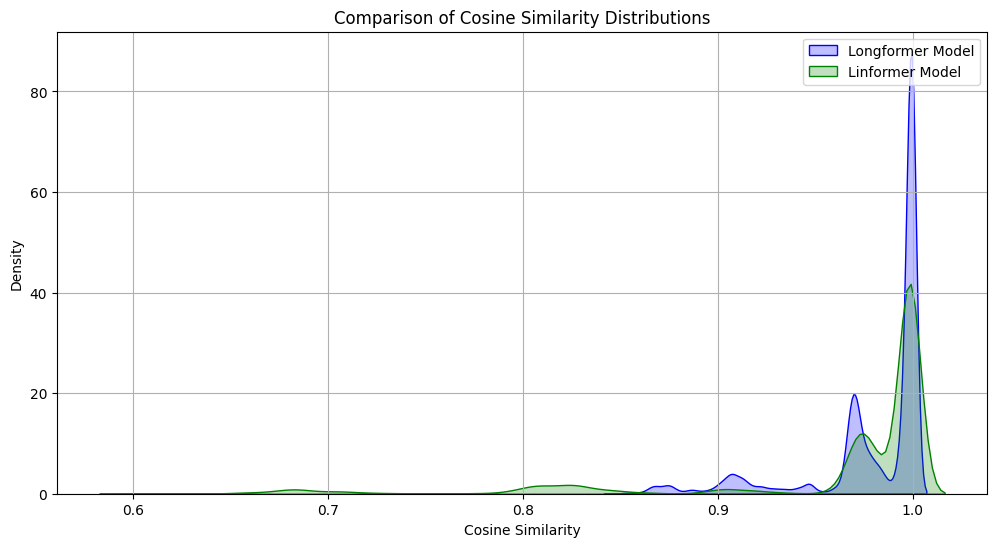

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming longformer_vector_df and linformer_vector_df have a column 'message_vector' with the vectors
# Stacking vectors into a 2D array for each model
longformer_vectors = np.stack(longformer_vector_df['message_vector'].to_numpy())
linformer_vectors = np.stack(linformer_vector_df['message_vector'].to_numpy())

# Calculate the cosine similarity matrix for each model
cosine_sim_matrix_long = cosine_similarity(longformer_vectors)
cosine_sim_matrix_lin = cosine_similarity(linformer_vectors)

# Extract the upper triangle values from each cosine similarity matrix, excluding the diagonal
upper_triangle_indices_long = np.triu_indices_from(cosine_sim_matrix_long, k=1)
cosine_sim_values_long = cosine_sim_matrix_long[upper_triangle_indices_long]

upper_triangle_indices_lin = np.triu_indices_from(cosine_sim_matrix_lin, k=1)
cosine_sim_values_lin = cosine_sim_matrix_lin[upper_triangle_indices_lin]

# Plotting the KDE of cosine similarities for both models
plt.figure(figsize=(12, 6))
sns.kdeplot(cosine_sim_values_long, color='blue', fill=True, label='Longformer Model')
sns.kdeplot(cosine_sim_values_lin, color='green', fill=True, label='Linformer Model')
plt.title('Comparison of Cosine Similarity Distributions')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()


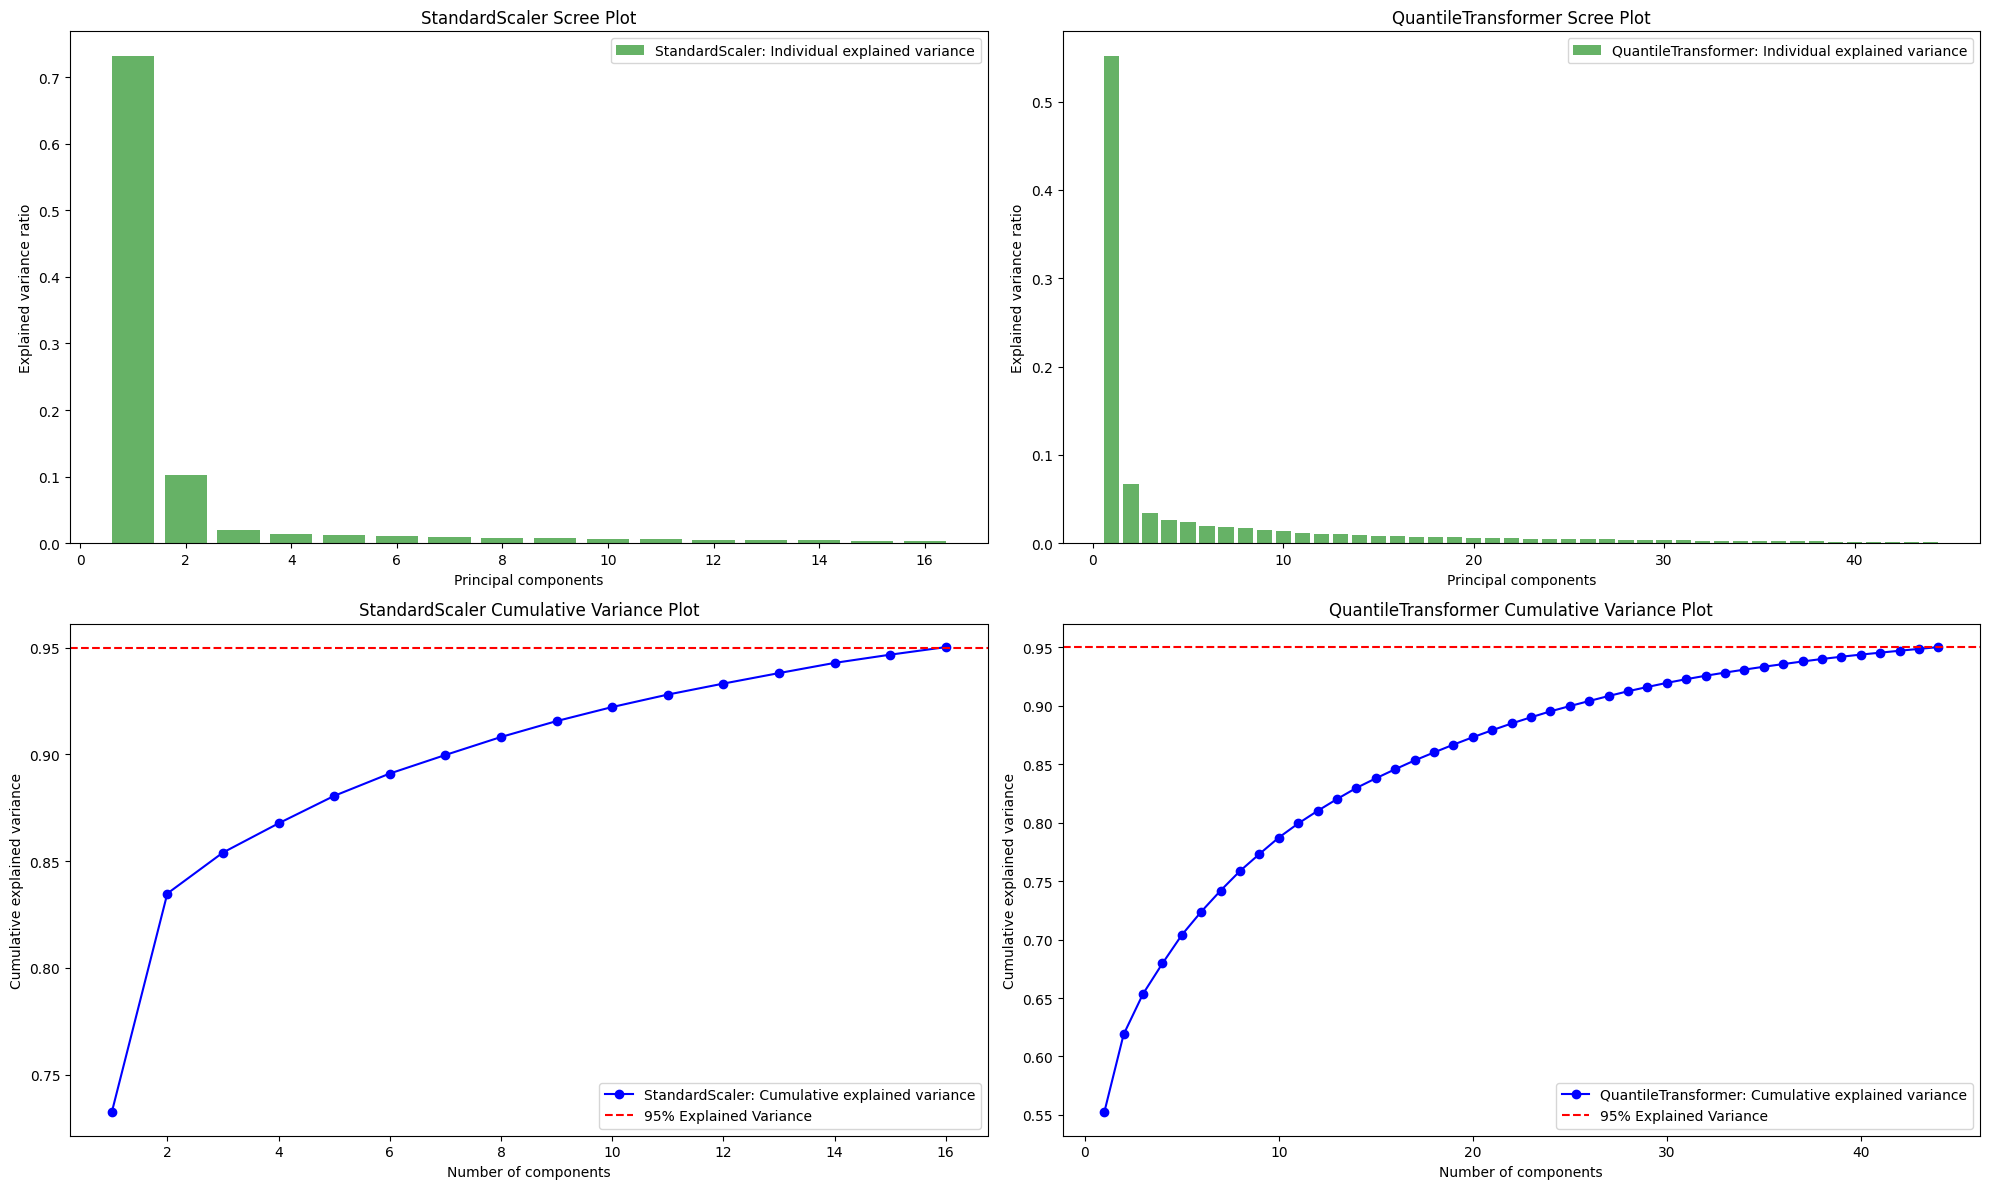

Number of components needed to explain 95% of variance (StandardScaler): 16
Number of components needed to explain 95% of variance (QuantileTransformer): 44


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer

# Assuming X is your feature matrix
X = linformer_vectors

def process_and_pca(X, scaler):
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    return explained_variance_ratio, cumulative_variance

# Process for StandardScaler
explained_variance_ratio_std, cumulative_variance_std = process_and_pca(X, StandardScaler())

# Process for QuantileTransformer
explained_variance_ratio_qt, cumulative_variance_qt = process_and_pca(X, QuantileTransformer(n_quantiles=1000, output_distribution='normal'))

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# Scree plot StandardScaler
axes[0, 0].bar(range(1, len(explained_variance_ratio_std) + 1), explained_variance_ratio_std, alpha=0.6, color='g', label='StandardScaler: Individual explained variance')
axes[0, 0].set_title('StandardScaler Scree Plot')
axes[0, 0].set_xlabel('Principal components')
axes[0, 0].set_ylabel('Explained variance ratio')
axes[0, 0].legend()

# Cumulative Variance plot StandardScaler
axes[1, 0].plot(range(1, len(cumulative_variance_std) + 1), cumulative_variance_std, marker='o', linestyle='-', color='b', label='StandardScaler: Cumulative explained variance')
axes[1, 0].axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
axes[1, 0].set_title('StandardScaler Cumulative Variance Plot')
axes[1, 0].set_xlabel('Number of components')
axes[1, 0].set_ylabel('Cumulative explained variance')
axes[1, 0].legend()

# Scree plot QuantileTransformer
axes[0, 1].bar(range(1, len(explained_variance_ratio_qt) + 1), explained_variance_ratio_qt, alpha=0.6, color='g', label='QuantileTransformer: Individual explained variance')
axes[0, 1].set_title('QuantileTransformer Scree Plot')
axes[0, 1].set_xlabel('Principal components')
axes[0, 1].set_ylabel('Explained variance ratio')
axes[0, 1].legend()

# Cumulative Variance plot QuantileTransformer
axes[1, 1].plot(range(1, len(cumulative_variance_qt) + 1), cumulative_variance_qt, marker='o', linestyle='-', color='b', label='QuantileTransformer: Cumulative explained variance')
axes[1, 1].axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
axes[1, 1].set_title('QuantileTransformer Cumulative Variance Plot')
axes[1, 1].set_xlabel('Number of components')
axes[1, 1].set_ylabel('Cumulative explained variance')
axes[1, 1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print the number of components needed to explain 95% of the variance
n_components_std = np.argmax(cumulative_variance_std >= 0.95) + 1
n_components_qt = np.argmax(cumulative_variance_qt >= 0.95) + 1

print(f"Number of components needed to explain 95% of variance (StandardScaler): {n_components_std}")
print(f"Number of components needed to explain 95% of variance (QuantileTransformer): {n_components_qt}")

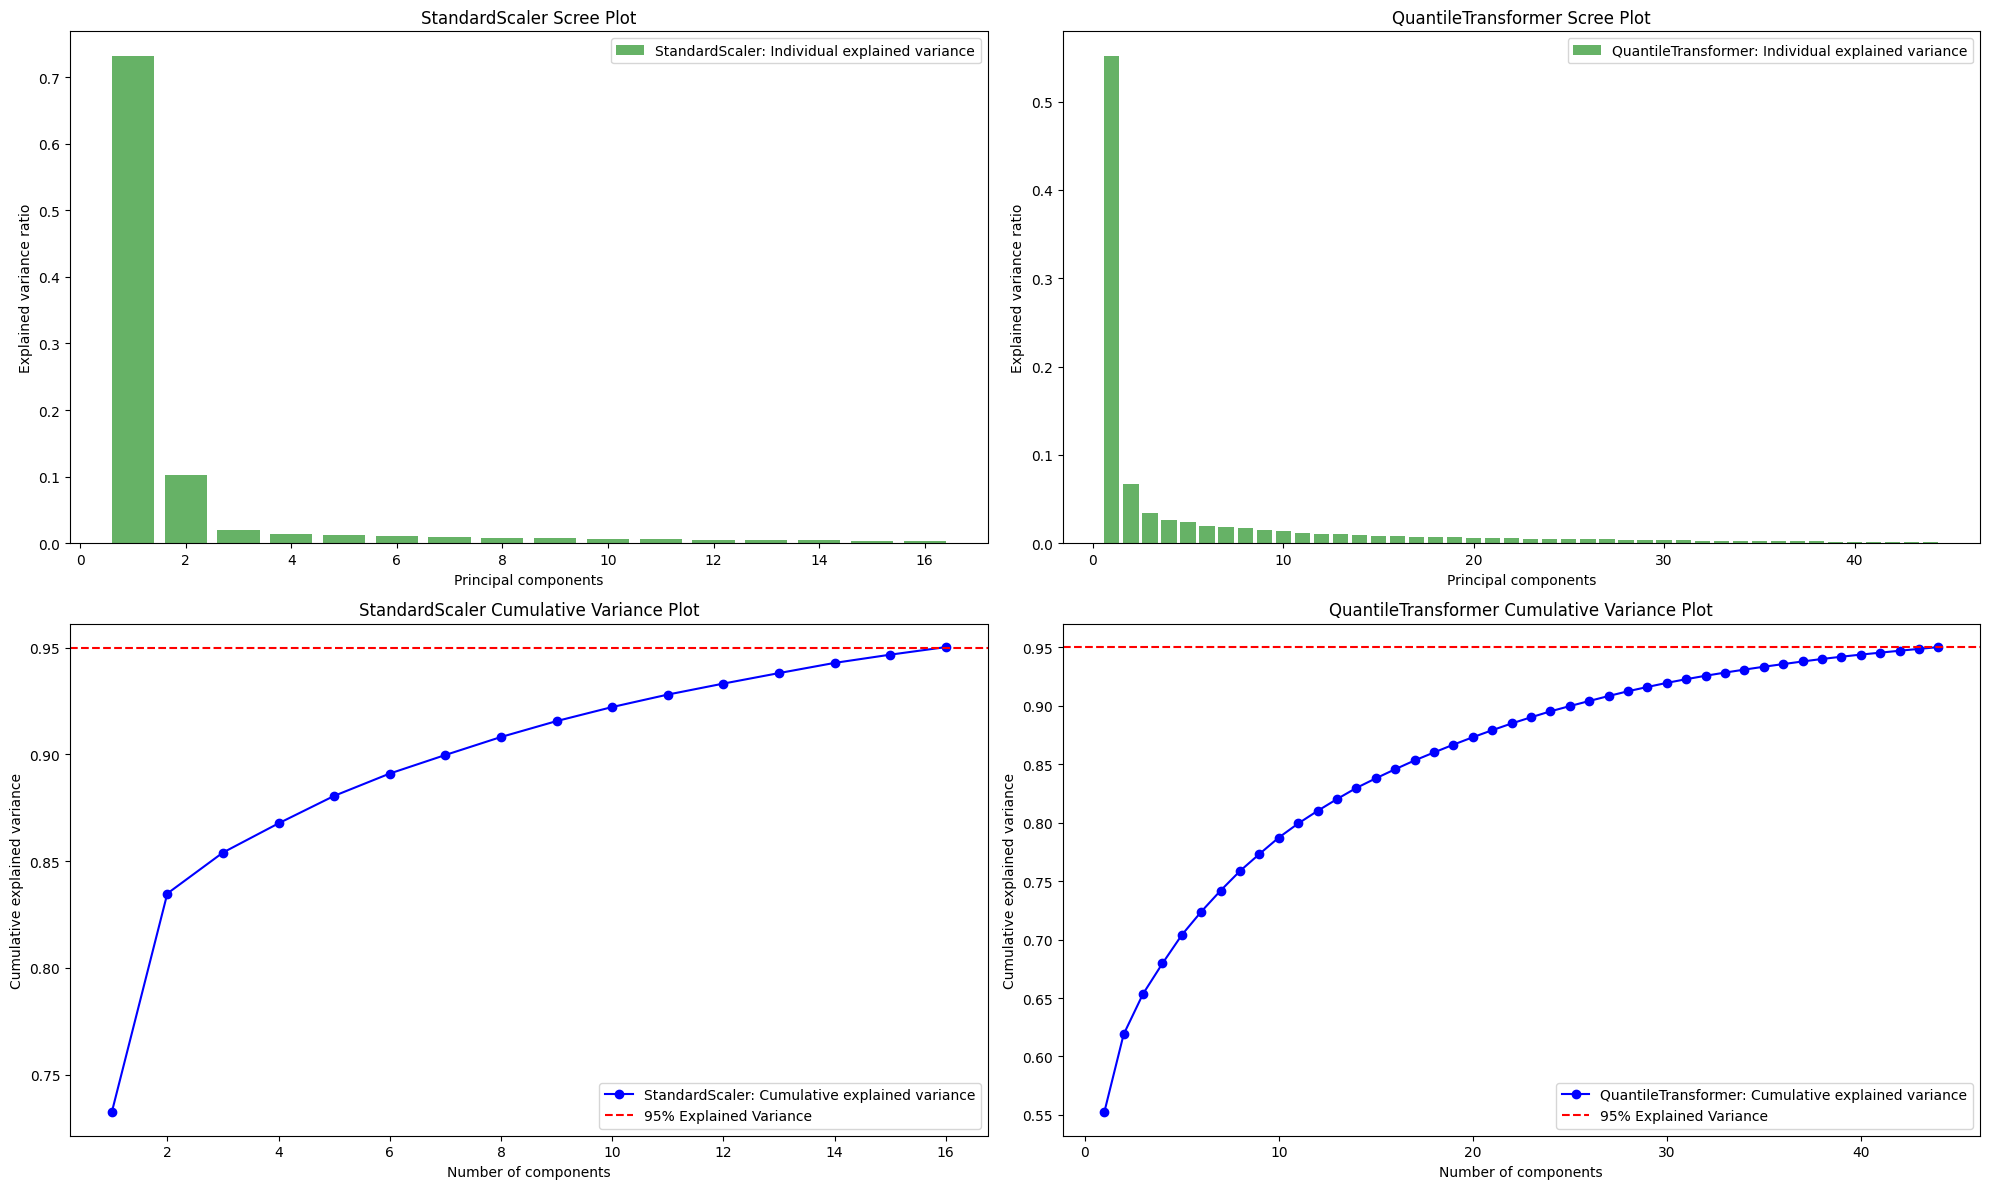

Number of components needed to explain 95% of variance (StandardScaler): 16
Number of components needed to explain 95% of variance (QuantileTransformer): 44


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer

# Assuming X is your feature matrix
X = linformer_vectors

# Process and plot for StandardScaler
scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X)
pca_std = PCA(n_components=0.95)
X_pca_std = pca_std.fit_transform(X_scaled_std)
explained_variance_ratio_std = pca_std.explained_variance_ratio_
cumulative_variance_std = np.cumsum(explained_variance_ratio_std)

# Process and plot for QuantileTransformer
scaler_qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
X_scaled_qt = scaler_qt.fit_transform(X)
pca_qt = PCA(n_components=0.95)
X_pca_qt = pca_qt.fit_transform(X_scaled_qt)
explained_variance_ratio_qt = pca_qt.explained_variance_ratio_
cumulative_variance_qt = np.cumsum(explained_variance_ratio_qt)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# Scree plot StandardScaler
axes[0, 0].bar(range(1, len(explained_variance_ratio_std) + 1), explained_variance_ratio_std, alpha=0.6, color='g', label='StandardScaler: Individual explained variance')
axes[0, 0].set_title('StandardScaler Scree Plot')
axes[0, 0].set_xlabel('Principal components')
axes[0, 0].set_ylabel('Explained variance ratio')
axes[0, 0].legend()

# Cumulative Variance plot StandardScaler
axes[1, 0].plot(range(1, len(cumulative_variance_std) + 1), cumulative_variance_std, marker='o', linestyle='-', color='b', label='StandardScaler: Cumulative explained variance')
axes[1, 0].axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
axes[1, 0].set_title('StandardScaler Cumulative Variance Plot')
axes[1, 0].set_xlabel('Number of components')
axes[1, 0].set_ylabel('Cumulative explained variance')
axes[1, 0].legend()

# Scree plot QuantileTransformer
axes[0, 1].bar(range(1, len(explained_variance_ratio_qt) + 1), explained_variance_ratio_qt, alpha=0.6, color='g', label='QuantileTransformer: Individual explained variance')
axes[0, 1].set_title('QuantileTransformer Scree Plot')
axes[0, 1].set_xlabel('Principal components')
axes[0, 1].set_ylabel('Explained variance ratio')
axes[0, 1].legend()

# Cumulative Variance plot QuantileTransformer
axes[1, 1].plot(range(1, len(cumulative_variance_qt) + 1), cumulative_variance_qt, marker='o', linestyle='-', color='b', label='QuantileTransformer: Cumulative explained variance')
axes[1, 1].axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
axes[1, 1].set_title('QuantileTransformer Cumulative Variance Plot')
axes[1, 1].set_xlabel('Number of components')
axes[1, 1].set_ylabel('Cumulative explained variance')
axes[1, 1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print the number of components needed to explain 95% of the variance
n_components_std = np.argmax(cumulative_variance_std >= 0.95) + 1
n_components_qt = np.argmax(cumulative_variance_qt >= 0.95) + 1

print(f"Number of components needed to explain 95% of variance (StandardScaler): {n_components_std}")
print(f"Number of components needed to explain 95% of variance (QuantileTransformer): {n_components_qt}")

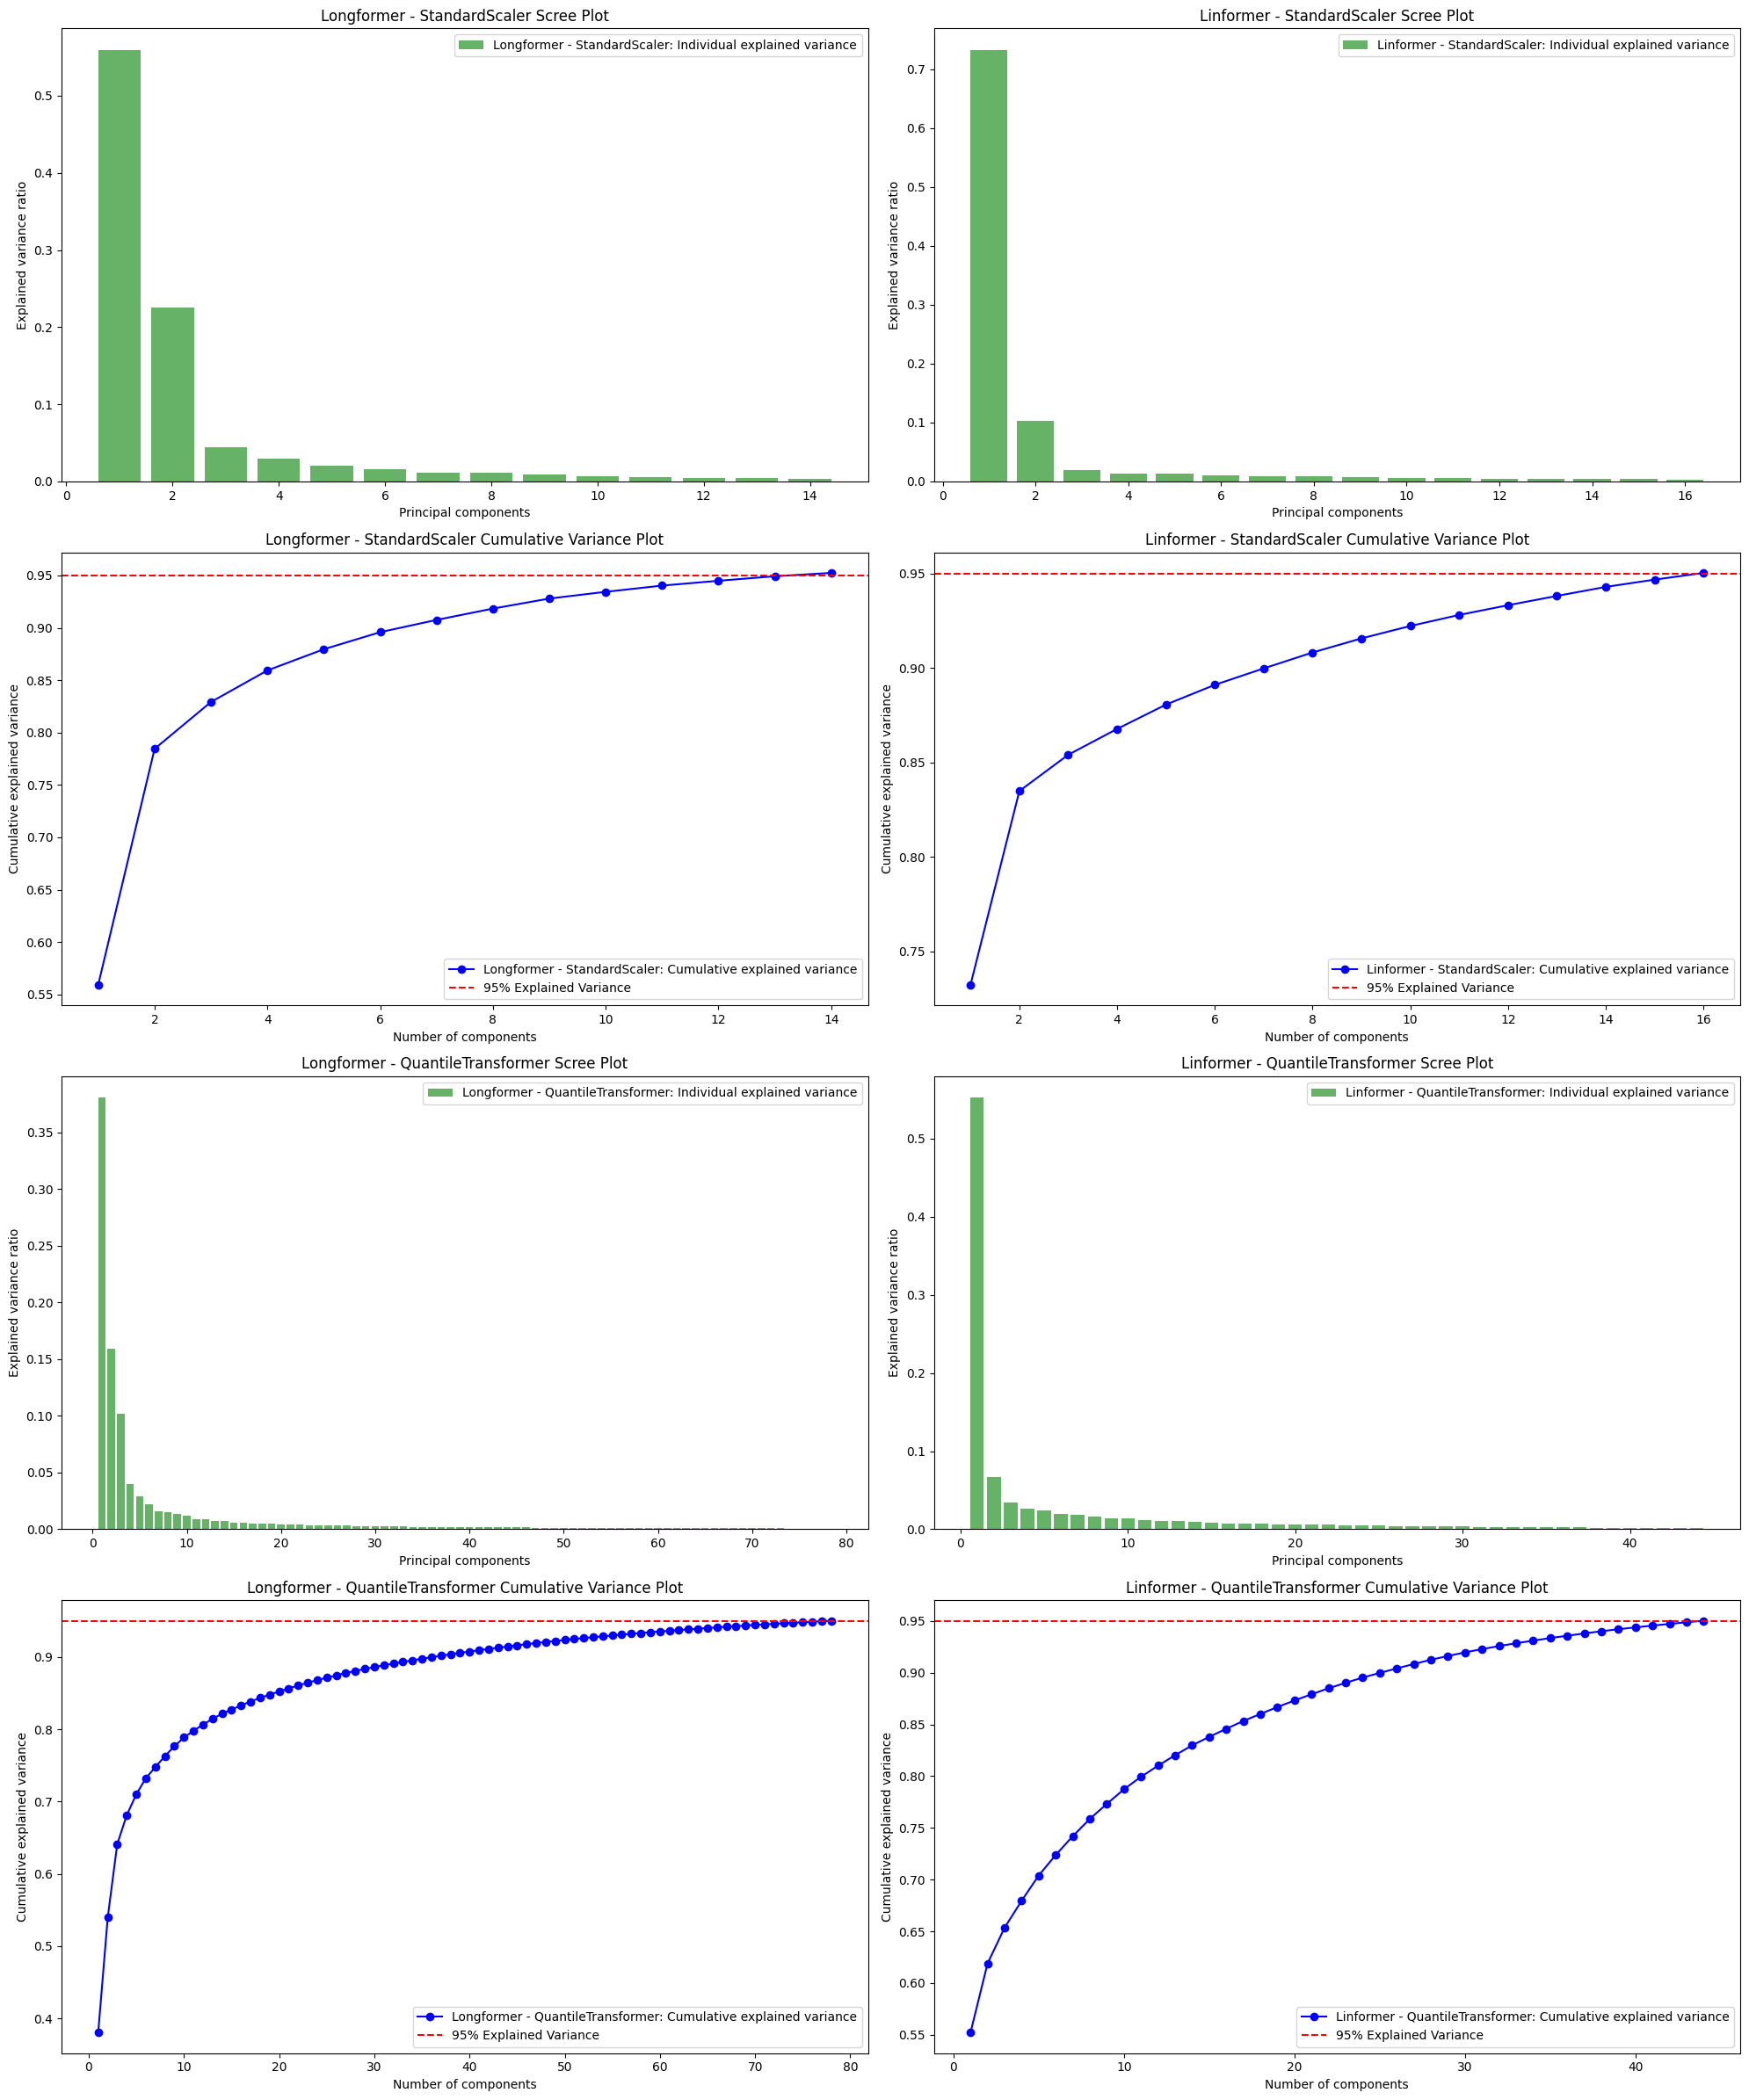

Number of components needed to explain 95% of variance:
Longformer (StandardScaler): 14
Longformer (QuantileTransformer): 78
Linformer (StandardScaler): 16
Linformer (QuantileTransformer): 44


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer

def process_and_plot(X, scaler, ax_scree, ax_cumulative, model_name, scaler_name):
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Scree plot
    ax_scree.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='g', label=f'{model_name} - {scaler_name}: Individual explained variance')
    ax_scree.set_title(f'{model_name} - {scaler_name} Scree Plot')
    ax_scree.set_xlabel('Principal components')
    ax_scree.set_ylabel('Explained variance ratio')
    ax_scree.legend()

    # Cumulative Variance plot
    ax_cumulative.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label=f'{model_name} - {scaler_name}: Cumulative explained variance')
    ax_cumulative.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    ax_cumulative.set_title(f'{model_name} - {scaler_name} Cumulative Variance Plot')
    ax_cumulative.set_xlabel('Number of components')
    ax_cumulative.set_ylabel('Cumulative explained variance')
    ax_cumulative.legend()

    return cumulative_variance

# Assuming linformer_vectors and longformer_vectors are defined elsewhere
x_lin = linformer_vectors
x_long = longformer_vectors

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 24))

# Process and plot for Longformer with StandardScaler
cv_long_std = process_and_plot(x_long, StandardScaler(), axes[0, 0], axes[1, 0], 'Longformer', 'StandardScaler')

# Process and plot for Longformer with QuantileTransformer
cv_long_qt = process_and_plot(x_long, QuantileTransformer(n_quantiles=1000, output_distribution='normal'), axes[2, 0], axes[3, 0], 'Longformer', 'QuantileTransformer')

# Process and plot for Linformer with StandardScaler
cv_lin_std = process_and_plot(x_lin, StandardScaler(), axes[0, 1], axes[1, 1], 'Linformer', 'StandardScaler')

# Process and plot for Linformer with QuantileTransformer
cv_lin_qt = process_and_plot(x_lin, QuantileTransformer(n_quantiles=1000, output_distribution='normal'), axes[2, 1], axes[3, 1], 'Linformer', 'QuantileTransformer')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print the number of components needed to explain 95% of the variance
print(f"Number of components needed to explain 95% of variance:")
print(f"Longformer (StandardScaler): {np.argmax(cv_long_std >= 0.95) + 1}")
print(f"Longformer (QuantileTransformer): {np.argmax(cv_long_qt >= 0.95) + 1}")
print(f"Linformer (StandardScaler): {np.argmax(cv_lin_std >= 0.95) + 1}")
print(f"Linformer (QuantileTransformer): {np.argmax(cv_lin_qt >= 0.95) + 1}")